# Latent Dirichlet Allocation (LDA)

LDA это вероятностная тематическая модель. Совместное распределение имеет следующий вид:
$$p(W, Z, \Theta, \Phi | \alpha, \eta) = \prod_{d=1}^D \Big( p(\theta_d | \alpha) \prod_{n=1}^{N_d} p(w_{d,n} | z_{d,n}, \Phi) p(z_{d,n} | \theta_d) \Big) \prod_{t=1}^T p(\phi_t | \eta) $$

Где:
$$p(\theta_d | \alpha) = Dir(\theta_d | \alpha)$$

$$p(w_{d,n} | z_{d,n}, \Phi) = Categorical(W_{d,n} | \phi_{z_{d,n}})$$

$$p(z_{d,n} | \theta_d) = Categorical(z_{d,n} | \theta_d)$$

$$p(\phi_t | \eta) = Dir(\phi_t | \eta)$$

В данном задании, вам предстоит применить тематическую модель LDA к датасету NIPS-papers. Нужно установить Python библиотеку `gensim` (её можно установить с помощью `pip`).

#### Мои рассуждения и ответы на вопросы в лабе выделены жирным.

In [1]:
import numpy as np
import scipy.io
from matplotlib import pyplot as plt
%matplotlib inline

import gensim

import logging

gensim.models.ldamodel.logger.setLevel(logging.ERROR)

Скачайте датасет и поместите его в папку с ноутбуком: 
http://www.cs.nyu.edu/~roweis/data/nips12raw_str602.mat

Код ниже выполняет необходимую предобработку данных.

In [2]:
nips12 = scipy.io.loadmat('nips12raw_str602.mat', squeeze_me=True)

# матрица размера <число документов> x <число слов>
counts = nips12['counts'].T

# оставим 2013 (~2000) наиболее употребимих слов
words_mask = np.ravel(counts.sum(axis=0) >= 121)
counts = counts[:, words_mask]

# отображение id -> word (необходимо для gensim)
nips12_id2word = {i: w for (i, w) in enumerate(nips12['wl'][words_mask])}

# отображение word -> id (необходимо для pyLDAvis)
nips12_word2id = {w: i for (i, w) in enumerate(nips12['wl'][words_mask])}

# Год проведения конференции. Значение 0 соответсвует 1988, 1 - 1989, и т.д.
nips12_issue = np.array([int(name[4:6]) for name in nips12['docnames']])

# Заголовки статей
nips12_titles = nips12['ptitles']

# Полный корпус в формате gensim
full_corpus = gensim.matutils.Scipy2Corpus(counts)

stream = np.random.RandomState(seed=123)
subset_mask = stream.rand(counts.shape[0]) <= 0.1

# Маленький корпус из 10% случайных статей для ускорения экспериментов
small_corpus = gensim.matutils.Scipy2Corpus(counts[subset_mask, :])

Gensim использует итеративный подход к выводу в модели LDA. Для получения новых значений вариационных параметров выполняется `iterations` итераций вариационного вывода. Далее, новые значения "блэндятся" со старыми (значениями из предыдущей итерации EM-алгоритма) посредством вычисления взвешенного среднего. Эта процедура повторяется `num_passes` раз. Такой подход позволяет предотвратить "застревание" метода в локальных оптимумах.

Используйте следующий шаблон для запуска LDA модели в Gensim. Сейчас мы используем подвыборку для ускорения вычислений.

Замечание: нижняя оценка связана с метрикой perplexity, которая обычно используется в естественных языках: $perplexity = exp(-bound)$

In [3]:
num_topics=10
def train_model(iterations, num_passes, alpha=[0.1] * num_topics):
    small_lda = gensim.models.LdaModel(
        corpus=small_corpus,
        passes=num_passes,
        num_topics=num_topics,
        alpha=alpha,
        iterations=iterations,
        id2word=nips12_id2word,
        eval_every=0,
        random_state=42
    )
    print('ELBO = {0:.4f}'.format(small_lda.bound(small_corpus)))

In [4]:
train_model(iterations=50, num_passes=5)

ELBO = -1494880.4988


Исследуйте влияние значений параметров `iterations` и `num_passes` на значние нижней оценки обученной модели.

In [5]:
iterations_range = [10, 50, 100, 1000]
num_passes_range = [1, 5, 10, 50]

for iterations in iterations_range:
    for num_passes in num_passes_range:
        print('iterations: {}    num passes: {}'.format(iterations, num_passes))
        train_model(iterations, num_passes)

iterations: 10    num passes: 1
ELBO = -1586290.3222
iterations: 10    num passes: 5
ELBO = -1529772.1945
iterations: 10    num passes: 10
ELBO = -1494179.1344
iterations: 10    num passes: 50
ELBO = -1472561.5671
iterations: 50    num passes: 1
ELBO = -1559751.4809
iterations: 50    num passes: 5
ELBO = -1494880.4988
iterations: 50    num passes: 10
ELBO = -1484833.3387
iterations: 50    num passes: 50
ELBO = -1473776.4591
iterations: 100    num passes: 1
ELBO = -1542971.3976
iterations: 100    num passes: 5
ELBO = -1493717.9319
iterations: 100    num passes: 10
ELBO = -1484906.5565
iterations: 100    num passes: 50
ELBO = -1474973.9397
iterations: 1000    num passes: 1
ELBO = -1523318.9606
iterations: 1000    num passes: 5
ELBO = -1492491.4962
iterations: 1000    num passes: 10
ELBO = -1484777.9120
iterations: 1000    num passes: 50
ELBO = -1475812.9052


|   ELBO         | iterations: 10 | iterations: 50 | iterations: 100 | iterations: 1000 |
|----------------|:--------------:|:--------------:|:---------------:|-----------------:|
| num passes: 1  | -1586290.3222  | -1559751.4809  | -1542971.3976   | -1523318.9606    |
| num passes: 5  | -1529772.1945  | -1494880.4988  | -1493717.9319   | -1492491.4962    |
| num passes: 10 | -1494179.1344  | -1484833.3387  | -1484906.5565   | -1484777.9120    |
| num passes: 50 | -1472561.5671  | -1473776.4591  | -1474973.9397   | -1475812.9052    |

#### С ростом числа итераций и независимо с ростом количества проходов по коллекции ELBO либо растёт либо не убывает (что значит, что метод сошёлся и некоторые итерации были лишними). К примеру в последней строке значения не сильно отличаются. Ещё можно заметить, что лучше увеличивать num_passes, чем iterations. Кстати, результаты экспериментов: ELBO, повторяется от запука к запуску, что приятно.

Исследуйте чувствительность нижней вариационную оценки к параметру априорного распределения $\alpha$. Используйте симметричные значения $\alpha$.

In [6]:
alphas = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 0.1, 0.2, 0.5, 2, 5, 10, 100]
for alpha in alphas:
    print('alpha: {}'.format(alpha))
    train_model(iterations=10, num_passes=50, alpha=[alpha] * num_topics)

alpha: 1e-06
ELBO = -1489525.6728
alpha: 1e-05
ELBO = -1485883.5710
alpha: 0.0001
ELBO = -1482262.8927
alpha: 0.001
ELBO = -1478684.3387
alpha: 0.01
ELBO = -1475241.0393
alpha: 0.1
ELBO = -1472561.5671
alpha: 0.2
ELBO = -1472237.5480
alpha: 0.5
ELBO = -1472515.4386
alpha: 2
ELBO = -1475795.0306
alpha: 5
ELBO = -1481125.1914
alpha: 10
ELBO = -1487418.4522
alpha: 100
ELBO = -1559492.2529


#### при значениях $\alpha < 1$ наблюдается относительно небольшая чувствительность ELBO от параметров $\alpha$ [$-1489 * 10^3$ : $-1472 * 10^3$]. То есть относительный прирость около сотой, что, кажется, немного. При изменениях $\alpha$ от 0.01 вплоть до 0.2. ELBO увеличилось от $-1475 * 10^3$ вплоть до $-1472 * 10^3$.


Обучите лучшую найденую модель на полной выборке.

In [7]:
%%time
num_topics = 10  # число тем в модели LDA
alpha = [0.2] * num_topics  # параметры априорного распределения Дирихле над распределениями документ/тема
iterations = 10  # число итераций вариационного вывода
num_passes = 50  # число проходов по датасету

lda = gensim.models.LdaModel(
    corpus=full_corpus,
    passes=num_passes,
    num_topics=num_topics,
    alpha=alpha,
    iterations=iterations,
    id2word=nips12_id2word,
    eval_every=0,
    random_state=42,
)
print('ELBO = {0:.4f}'.format(lda.bound(full_corpus)))

ELBO = -13802830.9161
CPU times: user 3min 4s, sys: 2.76 s, total: 3min 7s
Wall time: 3min 7s


Извлеките вариационные параметры $\gamma$ &mdash; параметры вариационной аппроксимации апостериорных вероятностей тем для документов: $q(\Theta_d) = Dir(\Theta_d | \gamma_d)$.

Нормализуйте их так, чтобы получить вероятностное распределение над темами для каждого документа (средние значения вероятностей в соответствии с распределением Дирихле).

#### Так как нормализовывать можно по-разному, дополнительно поясняю, что я беру моду распределения Дирихле

In [8]:
gamma, _ = lda.inference(full_corpus)
gamma = gamma - 1 / (gamma.sum(axis=1)[:, None] - 10)

Изобразите полученное апостериорное распределение вероятностей тем для нескольких документов. Сделайте это для документов разных годов. Меняется ли разреженность тем с течением времени? Как можно это объяснить?


In [9]:
gamma

array([[5.1060097e+01, 1.7524187e+01, 7.1588181e+01, ..., 1.1553314e+01,
        2.5710654e+02, 3.1986866e+01],
       [5.1060580e+02, 2.9972084e+01, 1.9506126e+02, ..., 3.5571690e+01,
        7.4179387e+00, 2.0977216e+02],
       [7.0800290e+00, 8.6119986e+00, 4.1266853e+01, ..., 1.6488128e+00,
        8.6122032e+01, 8.3961411e+01],
       ...,
       [3.2597670e-01, 1.6720127e+01, 6.9118317e+02, ..., 2.6716205e+02,
        4.1192085e+01, 6.2502125e+01],
       [2.0144641e-01, 2.0578039e-01, 7.6414008e+02, ..., 7.1719913e+00,
        1.7518509e+02, 4.6560310e+01],
       [2.5893753e+00, 7.1644511e+00, 9.2148663e+02, ..., 3.5027930e+02,
        3.9657421e+01, 7.4221172e+00]], dtype=float32)

In [10]:
(gamma < 1e-2).sum()

0

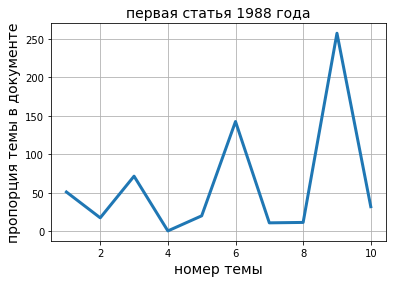

In [11]:
plt.plot(np.arange(10) + 1, gamma[0], linewidth=3)
plt.title('первая статья 1988 года', fontsize=14)
plt.xlabel('номер темы', fontsize=14)
plt.ylabel('пропорция темы в документе', fontsize=14)
plt.grid()

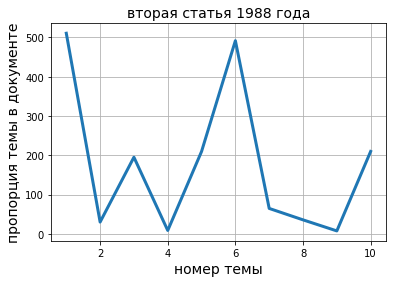

In [12]:
plt.plot(np.arange(10) + 1, gamma[1], linewidth=3)
plt.title('вторая статья 1988 года', fontsize=14)
plt.xlabel('номер темы', fontsize=14)
plt.ylabel('пропорция темы в документе', fontsize=14)
plt.grid()

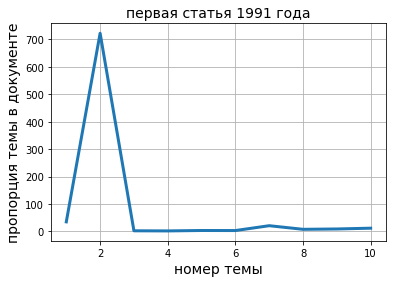

In [13]:
plt.plot(np.arange(10) + 1, gamma[nips12_issue == 3][0], linewidth=3)
plt.title('первая статья 1991 года', fontsize=14)
plt.xlabel('номер темы', fontsize=14)
plt.ylabel('пропорция темы в документе', fontsize=14)
plt.grid()

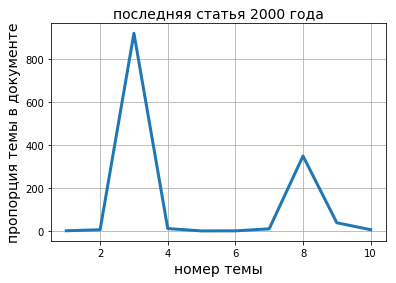

In [14]:
plt.plot(np.arange(10) + 1, gamma[-1], linewidth=3)
plt.title('последняя статья 2000 года', fontsize=14)
plt.xlabel('номер темы', fontsize=14)
plt.ylabel('пропорция темы в документе', fontsize=14)
plt.grid()

In [15]:
# средняя разреженность для документов каждого года
for i in range(13):
    print("{0} год: {1:.4f}".format(1988 + i, (gamma[nips12_issue == i] < 1e-2).mean()))

1988 год: 0.0000
1989 год: 0.0000
1990 год: 0.0000
1991 год: 0.0000
1992 год: 0.0000
1993 год: 0.0000
1994 год: 0.0000
1995 год: 0.0000
1996 год: 0.0000
1997 год: 0.0000
1998 год: 0.0000
1999 год: 0.0000
2000 год: 0.0000


#### Разреженность с каждым годом растёт (если игнорировать некоторые отдельные года, в которые происходят небольшие отклонения от общей тенденции). Также можно видеть для некоторых произвольно взятых статьях, что более поздние статьи отличаются монотематичностью или тем нет так много. Это может натолкнуть на мысль, что направленность статей стала более узкой со временем (сильное заявление, проверять я его, конечно, не буду).

Выведите наиболее вероятные слова и наиболее вероятные документы для каждой темы. Воспользуйтесь функциями `lda.num_topics`, `lda.show_topic(topic, topn=10)`. Используйте нормализованные параметры $\gamma$, вычисленные ранее.

Проанализируйте результат. Как вы можете интерпретировать темы? Напишите ваши интерпретации хотя бы для трёх тем.

Замечание. Если вы нашли интересную статью в списке, вы можете скачать её онлайн, публикации конференции NIPS доступны бесплатно.

In [16]:
gamma

array([[5.1060097e+01, 1.7524187e+01, 7.1588181e+01, ..., 1.1553314e+01,
        2.5710654e+02, 3.1986866e+01],
       [5.1060580e+02, 2.9972084e+01, 1.9506126e+02, ..., 3.5571690e+01,
        7.4179387e+00, 2.0977216e+02],
       [7.0800290e+00, 8.6119986e+00, 4.1266853e+01, ..., 1.6488128e+00,
        8.6122032e+01, 8.3961411e+01],
       ...,
       [3.2597670e-01, 1.6720127e+01, 6.9118317e+02, ..., 2.6716205e+02,
        4.1192085e+01, 6.2502125e+01],
       [2.0144641e-01, 2.0578039e-01, 7.6414008e+02, ..., 7.1719913e+00,
        1.7518509e+02, 4.6560310e+01],
       [2.5893753e+00, 7.1644511e+00, 9.2148663e+02, ..., 3.5027930e+02,
        3.9657421e+01, 7.4221172e+00]], dtype=float32)

### тема 1

In [17]:
lda.show_topic(0, topn=10)

[('time', 0.014679241),
 ('figure', 0.012155101),
 ('neuron', 0.011746328),
 ('input', 0.010234129),
 ('neurons', 0.009319921),
 ('circuit', 0.0090993075),
 ('analog', 0.008864959),
 ('model', 0.008508515),
 ('signal', 0.008491975),
 ('spike', 0.008344283)]

In [18]:
nips12_titles[np.flip(np.argsort(gamma[:, 0] / gamma[:, 0].sum()))][:10]

array(['An Analog VLSI Model of Periodicity Extraction,',
       'A Systematic Study of the Input/Output Properties of a 2 Compartment Model Neuron With Active Membranes ',
       'Computer Modeling of Associative Learning ',
       'Simulations Suggest Information Processing Roles for the Diverse Currents in Hippocampal Neurons ',
       'Improved Silicon Cochlea Using Compatible Lateral Bipolar Transistors ',
       'Information Capacity and Robustness of Stochastic Neuron Models, ',
       'A Passive Shared Element Analog Electrical Cochlea ',
       'VLSI Model of Primate Visual Smooth Pursuit ', 'A SILICON AXON ',
       'An Analog VLSI Model of the Fly Elementary Motion Detector,'],
      dtype=object)

### тема 2

In [19]:
# brain activity
lda.show_topic(1, topn=10)

[('model', 0.017978411),
 ('visual', 0.012877295),
 ('cells', 0.009995187),
 ('figure', 0.008769817),
 ('activity', 0.008569666),
 ('input', 0.0072150007),
 ('field', 0.006845869),
 ('neurons', 0.006788012),
 ('cell', 0.006633926),
 ('cortex', 0.006530519)]

In [20]:
nips12_titles[np.flip(np.argsort(gamma[:, 1] / gamma[:, 1].sum()))][:10]

array(['Partitioning of Sensory Data by a Cortical Network ',
       'A Computer Simulation of Olfactory Cortex with Functional Implications for Storage and Retrieval of Olfactory Information ',
       'OCULAR DOMINANCE AND PATTERNED LATERAL CONNFL-TIONS IN A SELF-ORGANIZING MODEL OFTHE PRIMARY VISUAL CORTEX ',
       'Can V1 Mechanisms Account for Figure-Ground and Medial Axis Effects ?,',
       'Neural Basis of Object-Centered Representations,',
       'Centric Models of the Orientation Map in Primary Visual Cortex ',
       'Toward a Single-Cell Account for Binocular Disparity Tuning: An Energy Model May Be Hiding in Your Dendrites� ',
       'Recurrent Cortical Amplification Produces Complex Cell Responses, ',
       'The Role of Lateral Cortical Competition in Ocular Dominance Development,',
       'A Neural Model of Visual Contour Integration,'], dtype=object)

### тема 3

In [21]:
# RL
lda.show_topic(2, topn=10)

[('learning', 0.032115575),
 ('state', 0.027793147),
 ('time', 0.016784832),
 ('control', 0.0154049555),
 ('model', 0.011803023),
 ('function', 0.009059944),
 ('states', 0.008453872),
 ('system', 0.008380923),
 ('algorithm', 0.0079247365),
 ('action', 0.0075426777)]

In [22]:
nips12_titles[np.flip(np.argsort(gamma[:, 2] / gamma[:, 2].sum()))][:10]

array(['Learning from Demonstration,',
       'Reinforcement Learning for Mixed Open-loop and Closed-loop Control,',
       'Learning by State Recurrence Detection ',
       'Reinforcement Learning with Hierarchies of Machines, ',
       'Integrated Modeling and Control Based on Reinforcement Learning . ',
       'An Improved Policy Iteration Algorithm for Partially Observable MDPS, ',
       'Sequential Decision Problems and Neural Networks ',
       'Learning Macro-Actions in Reinforcement Learning,',
       'FINDING STRUCTURE IN REINFORCEMENT LEARN1NG ',
       'Multi-time Models for Temporally Abstract Planning,'],
      dtype=object)

### тема 4

In [23]:
# ML for speech recognition
lda.show_topic(3, topn=10)

[('recognition', 0.019668093),
 ('training', 0.01794111),
 ('network', 0.013557082),
 ('speech', 0.012263199),
 ('set', 0.011108487),
 ('performance', 0.010352205),
 ('system', 0.010164242),
 ('neural', 0.010061756),
 ('features', 0.008579699),
 ('image', 0.008250364)]

In [24]:
nips12_titles[np.flip(np.argsort(gamma[:, 3] / gamma[:, 3].sum()))][:10]

array(['Context-Dependent Multiple Distribution Phonetic Modeling with MLPs',
       'Making Templates Rotationally Invariant: An Application to Rotated Digit Recognition,',
       'HMM Speech Recognition with Neural Net Discrimination ',
       'A Hybrid Neural Net System for State-of-the-Art Continuous Speech Recognition ',
       'Multi-State Time Delay Neural Networks for Continuous Speech Recognition',
       'A Continuous Speech Recognition System Embedding MLP into HMM ',
       'Comparison of Human and Machine Word Recognition,',
       'Human Face Detection in Visual Scenes ',
       'Recognizing Overlapping Hand-Printed Characters by Centered-Object Integrated Segmentation and Recognition ',
       'A CONVOLUTIONAL NEURAL NETWORK HAND TRACKER '], dtype=object)

### тема 5

In [26]:
nips12_titles[np.flip(np.argsort(gamma[:, 4] / gamma[:, 4].sum()))][:10]

array(['Analysis of Distributed Representation of Constituent Structure in Connectionist Systems ',
       'Connecting to the Past ',
       'Rule Induction through Integrated Symbolic and Subsymbolic Processing ',
       'The Recurrent Cascade-Correlation Architecture . ',
       'A Connectionist Symbol Manipulator that Discovers the Structure of Context-Free Languages ',
       'Learning Sequential Tasks by Incrementally Adding Higher Orders',
       'Learning Sequential Structure in Simple Recurrent Networks ',
       'Analyzing Cross-Connected Networks ',
       'Higher Order Recurrent Networks and Grammatical Inference ',
       'The Cascade-Correlation Learning Architecture'], dtype=object)

### тема 6

In [27]:
# neural nets
lda.show_topic(5, topn=10)

[('network', 0.038999334),
 ('neural', 0.02301185),
 ('networks', 0.018775124),
 ('memory', 0.012736396),
 ('input', 0.00969719),
 ('number', 0.009356469),
 ('time', 0.008896325),
 ('output', 0.008578292),
 ('weight', 0.008481579),
 ('patterns', 0.0072854506)]

In [28]:
nips12_titles[np.flip(np.argsort(gamma[:, 5] / gamma[:, 5].sum()))][:10]

array(['Introduction to a System for Implementing Neural Net Connections on SIMD Architectures ',
       'A Neural Network to Detect Homologies in Proteins ',
       "Capacity for Patterns and Sequences in Kanerva's SDM as Compared to Other Associative Memory Models ",
       'Neural Network Implementation Approaches for the Connection Machine ',
       'Basins of Attraction for Electronic Neural Networks ',
       'Dynamics of Analog Neural Networks with Time Delay ',
       'A Trellis-Structured Neural Network ',
       "Predicting Weather Using a Genetic Memory: A Combination of Kanerva's Sparse Distributed Memory with Holland's Genetic Algorithms ",
       'Bit-Serial Neural Networks ',
       'Learning in Networks of Nondeterministic Adaptive Logic Elements '],
      dtype=object)

### тема 7

In [29]:
# optimization
lda.show_topic(6, topn=10)

[('algorithm', 0.014552101),
 ('matrix', 0.014528275),
 ('linear', 0.011388568),
 ('learning', 0.009744831),
 ('vector', 0.009497518),
 ('gradient', 0.009294407),
 ('function', 0.008833637),
 ('point', 0.0070936964),
 ('information', 0.0068386784),
 ('space', 0.0068281987)]

In [30]:
nips12_titles[np.flip(np.argsort(gamma[:, 6] / gamma[:, 6].sum()))][:10]

array(['Constrained Differential Optimization ',
       'One-unit Learning Rules for Independent Component Analysis,',
       'Application of Blind Separation of Sources to Optical Recording of Brain Activity,',
       'Edges are the "Independent Components" of Natural Scenes, ',
       'Semiparametric Approach to Multichannel Blind Deconvolution of Nonminimum Phase Systems,',
       'Extended ICA Removes Artifacts from Electroencephalographic Recordings,',
       'Algorithms for Independent Components Analysis and Higher Order Statistics,',
       'Learning Lie Groups for Invariant Visual Perception,',
       'Multi-effect Decompositions for Financial Data Modeling,',
       'Blind Separation of Radio Signals in Fading Channels,'],
      dtype=object)

### тема 8

In [31]:
# some probabilistic ML algorithm
lda.show_topic(7, topn=10)

[('data', 0.029263562),
 ('model', 0.02150584),
 ('models', 0.012083919),
 ('distribution', 0.010284626),
 ('gaussian', 0.009998055),
 ('set', 0.009399633),
 ('probability', 0.008571789),
 ('parameters', 0.008528386),
 ('algorithm', 0.008276205),
 ('likelihood', 0.007306037)]

In [32]:
nips12_titles[np.flip(np.argsort(gamma[:, 7] / gamma[:, 7].sum()))][:10]

array(['Stacked Density Estimation,',
       'Variational Inference for Bayesian Mixtures of Factor AnaIysers,',
       'Supervised Learning from Incomplete Data via an EM Approach ',
       'Discovering Structure in Continuous Variables Using Bayesian Networks ',
       'Clustering Sequences with Hidden Markov Models,',
       'Nonlinear Markov Networks for Continuous Variables, ',
       'A VariationaI Baysian Framework for Graphical Models,',
       'Reconstruction of Sequential Data with Probabilistic Models and Continuity Constraints,',
       'Learning Mixture Hierarchies, ',
       'Fisher Scoring and a Mixture of Modes Approach for Approximate Inference and  Learning in Nonlinear State Space Models, '],
      dtype=object)

### тема 9

In [33]:
# optimization
lda.show_topic(8, topn=10)

[('function', 0.02213905),
 ('functions', 0.01549844),
 ('set', 0.011774311),
 ('algorithm', 0.010346972),
 ('number', 0.009604152),
 ('theorem', 0.008293394),
 ('class', 0.007913775),
 ('bound', 0.0074264873),
 ('case', 0.0074140257),
 ('networks', 0.007315124)]

In [34]:
nips12_titles[np.flip(np.argsort(gamma[:, 8] / gamma[:, 8].sum()))][:10]

array(['Computing with Almost Optimal Size Neural Networks ',
       'The Perceptron Algorithm Is Fast for Non-Malicious Distributions ',
       'Boosting with Multi-Way Branching in Decision Trees,',
       'Lower Bounds on the Complexity of Approximating Continuous Functions by SigmoidaI Neural Networks,',
       'Linear Hinge Loss and Average Margin, ', 'Potential Boosters?,',
       'What Size Net Gives Valid Generalization? ',
       'Generalization in Decision Trees and DNF: Does Size Matter? ',
       'The Power of Approximating: A Comparison of Activation Functions',
       'Large Margin DAGs for Multiclass Classification,'], dtype=object)

### тема 10

In [35]:
# neural nets
lda.show_topic(9, topn=10)

[('error', 0.025360666),
 ('learning', 0.023106499),
 ('training', 0.02078068),
 ('networks', 0.010394824),
 ('network', 0.010335704),
 ('generalization', 0.009950273),
 ('weight', 0.0097991),
 ('function', 0.009598022),
 ('set', 0.009287448),
 ('neural', 0.009111673)]

In [36]:
nips12_titles[np.flip(np.argsort(gamma[:, 9] / gamma[:, 9].sum()))][:10]

array(['Online Learning from Finite Training Sets: An Analytical Case Study,',
       'Learning with Ensembles: How Overfitting Can Be Useful ',
       'LEARNING FROM QUERIES FOR MAXIMUM INFORMATION GAIN IN IMPERFECTLY LEARNABLE PROBLEMS ',
       'The Learning Dynamcis of a Universal Approximator,',
       'Learning with Noise and Regularizers in Multilayer Neural Networks, ',
       'NEURAL NETWORK ENSEMBLES, CROSS VALIDATION, AND ACTIVE LEARNING ',
       'Adaptive Back-Propagation in On-line Learning of Multilayer Networks ',
       'Generalization by Weight-Elimination with Application to Forecasting . ',
       'Dynamics of On-line Gradient Descent Learning for Multilayer Neural Networks ',
       'Statistical Mechanics of Learning in a Large Committee Machine'],
      dtype=object)

Вычислите среднюю вероятность тем для каждого года. Проанализируйте какие темы становятся более популярны с теченим времени, а какие, наоборот, теряют популярность.

In [37]:
a = gamma[nips12_issue == 0].mean(axis=0)
for i in range(1, 13):
    a = np.vstack((a, gamma[nips12_issue == i].mean(axis=0)))
    print("{} год:".format(1988 + i))
    print(gamma[nips12_issue == i].mean(axis=0))

1989 год:
[177.52837  140.843     56.088634 109.162025 187.11406  171.92429
  72.31759   31.90036   55.316853  71.29871 ]
1990 год:
[124.48408  168.99162   63.122536 154.71388  160.98438  171.2435
  61.266163  51.143215  67.502045  81.46916 ]
1991 год:
[ 91.265854 117.79511   84.48571  145.85722  156.27522  119.78621
  65.64216   50.199776  91.26547   86.2208  ]
1992 год:
[104.50268  144.02704   88.78401  152.46146  164.31868   84.18489
  73.90557   93.64163   96.59635  103.929276]
1993 год:
[100.9456   153.55249  102.17563  145.8694   155.27805   84.65008
  74.61181   89.1762    95.99945  124.306694]
1994 год:
[ 93.65099  102.909904 116.37336  140.03453  130.14789  100.05525
  92.17429  122.658134  82.666885 128.29156 ]
1995 год:
[ 74.72555  155.56757  123.390015 144.26021  128.70174   79.46257
  97.61433  143.42038   71.506096 152.22127 ]
1996 год:
[115.10973  121.23484  123.984055 125.1871    90.92869   70.371025
  87.694016 136.16167  128.09888  135.50385 ]
1997 год:
[ 90.370766 11

In [38]:
a.shape

(13, 10)

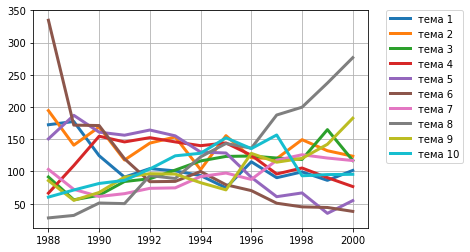

In [39]:
for i in range(10):
    plt.plot(1988 + np.arange(13), a[:, i], linewidth=3, label='тема {}'.format(i + 1))
plt.grid()
plt.legend(loc='right', bbox_to_anchor=(0.8, 0.4, 0.5, 0.5))

### темы 8 ,9 (оптимизация) набирает популярность;
### темы 1, 5 (нейросети), 6 (нейросети) наоборот - теряют;
### темы 2, 3, 4 (распознавание речи), 7 (оптимизация), 10 (снова что-то о нейросетях) актуальны постоянно.

Используйте следующий код для отображения тем, найденных LSI (Latent Semantic Indexing) &mdash; невероятностной тематической моделью. Как можно интерпретироват полученные темы? Сравните время работы методов.

In [40]:
lsi = gensim.models.LsiModel(full_corpus, num_topics=num_topics, id2word=nips12_id2word)
lsi.print_topics(10, num_words=20)

[(0,
  '0.293*"network" + 0.263*"learning" + 0.207*"model" + 0.204*"neural" + 0.188*"input" + 0.167*"training" + 0.167*"data" + 0.164*"networks" + 0.162*"time" + 0.161*"function" + 0.158*"set" + 0.152*"figure" + 0.127*"output" + 0.119*"algorithm" + 0.118*"error" + 0.113*"number" + 0.109*"system" + 0.107*"units" + 0.104*"state" + 0.094*"results"'),
 (1,
  '0.498*"network" + -0.333*"learning" + 0.222*"input" + -0.209*"algorithm" + -0.208*"data" + -0.196*"model" + 0.188*"neural" + 0.167*"networks" + 0.158*"units" + 0.151*"output" + -0.128*"state" + -0.123*"function" + 0.115*"layer" + 0.096*"unit" + 0.090*"neurons" + -0.088*"models" + -0.080*"distribution" + 0.078*"hidden" + -0.077*"policy" + -0.075*"algorithms"'),
 (2,
  '-0.473*"model" + 0.238*"training" + 0.228*"learning" + 0.205*"network" + -0.179*"cells" + 0.174*"error" + -0.156*"neurons" + 0.155*"networks" + -0.149*"cell" + -0.147*"visual" + -0.132*"figure" + -0.119*"time" + -0.118*"neuron" + 0.117*"set" + -0.113*"response" + 0.106*"

In [41]:
%%time
lsi = gensim.models.LsiModel(full_corpus, num_topics=num_topics, id2word=nips12_id2word)

CPU times: user 3.41 s, sys: 94 ms, total: 3.51 s
Wall time: 3.39 s


#### В теме 4 появляются слова " speech" и "recongition". В 3ю тему попадают слова связанные в теорией вероятностей такие как "gaussian", "probabilistic". Похожие темы выдавала LDA. Также в 3ю тему попадают слова про RL ("policy", "gradient"), правда с отрицательным весом, в темах, полученных с помощью LDA явно не удалось найти тему про RL. Так же, как и в LDA, в топе нескольких тем LSI есть слова про нейронные сети. В общем результаты работы методов похожие. При этом LSI обучается примерно за 3 секунды, а 10 итераций по 50 проходов по корпусу выполняются примерно за 3 минуты (хотя возможно не стоило задавать такое большое количество iterations и num_passes).

# Визуализация

Используйте следующий код для изображения тем вашей лучшей модели.

In [42]:
class MyDictionary():
    def __init__(self, word2id):
        self.token2id = word2id
    
    def __len__(self):
        return len(self.token2id)

class MyScipy2Corpus(gensim.matutils.Scipy2Corpus):
    def __len__(self):
        return self.vecs.shape[0]

In [43]:
lda.save('model.dat')

Установите библиотеку `pyLDAvis` с помощью `pip`

**Найдите две наиболее похожие темы.**

In [44]:
import pyLDAvis.gensim

lda = gensim.models.LdaModel.load('model.dat')
my_full_corpus = MyScipy2Corpus(counts[subset_mask, :])
my_dictionary = MyDictionary(nips12_word2id)
data = pyLDAvis.gensim.prepare(lda, my_full_corpus, my_dictionary)
pyLDAvis.display(data)

/usr/local/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


#### Темы 3, 5 и 6 довольно похожи, исходя из графика, и если посмотреть на топ-слова этих тем, станет ясно, что они все о нейронных сетях. Однако есть ещё тема 1, которая почти полностью "накрывает" тему 8, хотя не сказать, что они об одном и том же: тема 1 про мозговую активность (похоже на то), а тема 8 про чипы и схемы.